# RL homework 1

Submitted by: Faisal Omari - 325616894,  Mayas Ghantous - 213461692.

**Due date: 14 February 2024, 23:55am**

## How to submit

Submissions in pairs only.

You should save a copy of the notebook to Google Drive and open it with Google Colab. Then answer all the questions inside the notebook, at the designated cells. Only the notebook will be submitted in moodle (in `.ipynb` format).

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output).
    
When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'.

Then submit the downloaded '.ipynb' file to Moodle.

## Context

In this assignment, we will take a first look at learning decisions from data.  

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [53]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

OSError: 'seaborn-notebook' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

### A grid world

In [ ]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)

    self._state = new_state

    return reward, discount, self.get_obs()

### Helper functions

In [ ]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    log_every = 100
    mean_reward_log = np.zeros(number_of_steps//log_every-1)
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)
      if i>0 and i % log_every == 0:
        mean_reward_log[i//log_every-1] = mean_reward
    return mean_reward, mean_reward_log


def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


# Part 1: Implement agents

Each agent, should implement a step function:

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

In this assignment, observations will be states in the environment, so the agent state, environment state, and observation will overlap, and we will use the word `state` interchangably with `observation`.

All agents should be in pure Python (no need to use TensorFlow or PyTorch).  Using `numpy` is fine.

### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  In our experiments the helper functions above will just use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```


### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

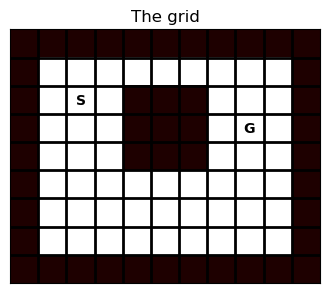

In [ ]:
grid = Grid()
grid.plot_grid()
num_actions = 4

## Random agent

In [ ]:
# For reference: here is a random agent
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(number_of_actions)
    return next_action


## Agent 1: TD learning
**[5 pts]** Implement an agent that behaves randomly, but that _on-policy_ estimates state values $v(s)$, using one-step TD learning with a step size $\alpha=0.1$.

Also implement `get_values(self)` that returns the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement `get_values` and `step`.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  Hint: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [ ]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  def get_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    """TODO: Implement"""
    self.previous_state = self._state
    self._state = next_state
    next_action = np.random.randint(self._number_of_actions)
    
    td_target = reward + discount * self._values[self._state]
    td_error = td_target - self._values[self.previous_state]
    self._values[self.previous_state] +=self._step_size*td_error

    
    return next_action

Run the next cell to run the `RandomTD` agent on a grid world.

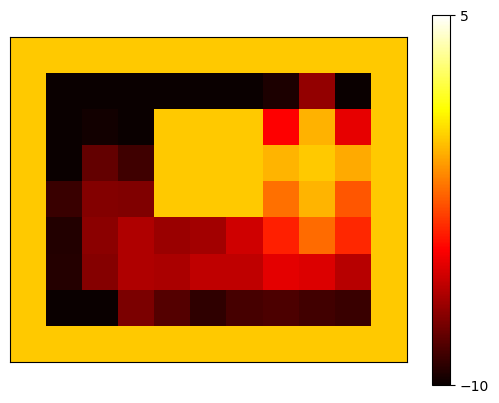

In [57]:
# DO NOT MODIFY THIS CELL
grid = Grid()
init_state = grid.get_obs()
agent = RandomTD(grid._layout.size, num_actions, init_state)
run_experiment(grid, agent, int(1e5))
v = agent.get_values()
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

If everything worked as expected, the plot above will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange above).

### Policy iteration
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model - so for each state the policy would look at the value of the resulting state for each action, and would then pick the action with the highest state value. You do **not** have to implement this, just answer the following questions.

**[5 pts]** Would the greedy step after one such iteration of policy evaluation and policy improvement be optimal on this problem?  Explain (in one or two sentences) why or why not.

**[5 pts]** If we repeat the process over and over again, and repeatedly evaluate the greedy policy and then perform another improvement step, would then the policy eventually become optimal?  Explain (in one or two sentences) why or why not.


## Agent 2: SARSA
**[5 pts]** Implement an $\epsilon$-greedy policy function.

**[10 pts]** Implement a **Sarsa** agent. Now the `__init__` function receives a policy function as input, and you need to maintain a value function for (state, action) pairs, denoted by  **Q**.


In [28]:
class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action(self, Qvalues, state):
    """TODO: Implement"""
    random_number = np.random.rand()
    if random_number<=self._epsilon:
      return np.random.randint(Qvalues.shape[1])
    else:
      max = -np.Infinity
      action = 0
      for j in range(Qvalues.shape[1]):
        if Qvalues[state][j]>max:
          max = Qvalues[state][j]
          action = j

      return action


In [29]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions,
               policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    """TODO: Implement"""
    next_action = self._policy.get_action(self._Qvalues,next_state)
    self._Qvalues[self._state][self._action] +=self._step_size*(reward+discount*self._Qvalues[next_state][next_action] - self._Qvalues[self._state][self._action])
    self._state = next_state
    self._action = next_action
    
    return next_action



Run the next cell. This will train your Sarsa agent using an $\epsilon$-greedy policy with $\epsilon=0.1$.

After training a state value is computed using a one-step greedy evaluation:
$V(s) = \max_a Q(s, a)$

The figure on the left shows the value for each state in the grid, and the plot on the right shows the average reward received along the training episodes(always averaged from the first step).

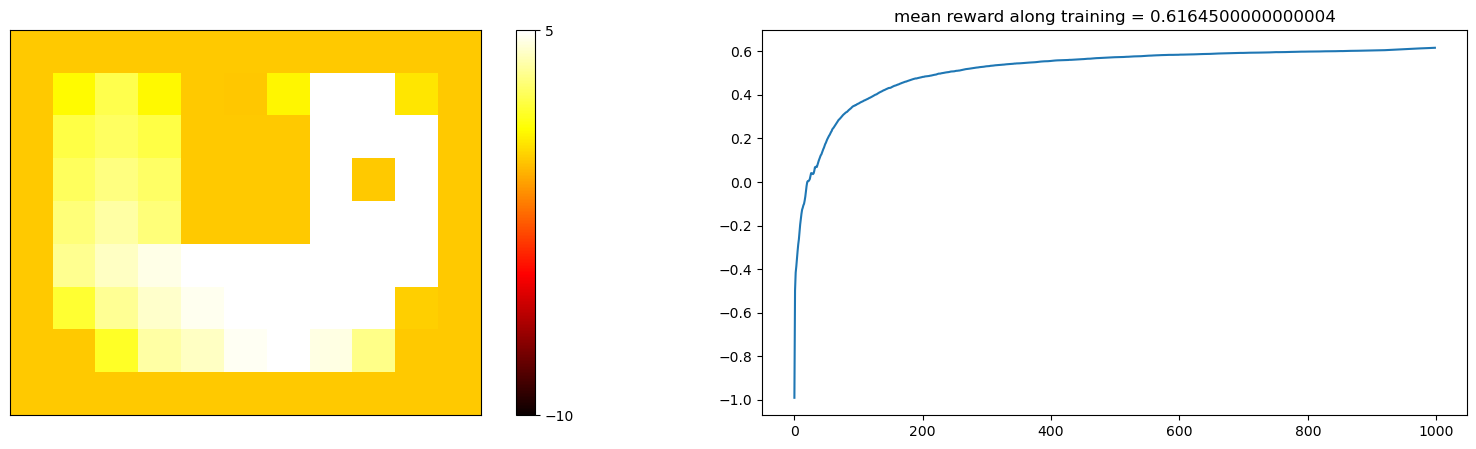

In [30]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = Sarsa(grid._layout.size, num_actions, policy, init_state)

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))



## Agent 3: Sarsa($\lambda$)
**[10 pts]** Implement a **Sarsa($\lambda$)** agent.
Now you need to maintain a table of eligibility traces, and update the Q-value of all (state, action) pairs in each step.


In [31]:
class SarsaLambda(object):

  def __init__(self, number_of_states, number_of_actions,
               lmbda, policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._Etraces = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._lmbda = lmbda
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    """TODO: Implement"""
    next_action = self._policy.get_action(self._Qvalues,next_state)
    delta = reward +discount*self._Qvalues[next_state][next_action] - self._Qvalues[self._state][self._action]
    self._Etraces[self._state][self._action]+=1
    for current_state in range(self._Qvalues.shape[0]):
      for current_action in range(self._Qvalues.shape[1]):
        self._Qvalues[current_state][current_action]+= self._step_size * delta*self._Etraces[current_state][current_action]
        self._Etraces[current_state][current_action] = discount*self._lmbda*self._Etraces[current_state][current_action]
    self._state = next_state
    self._action = next_action

    return next_action



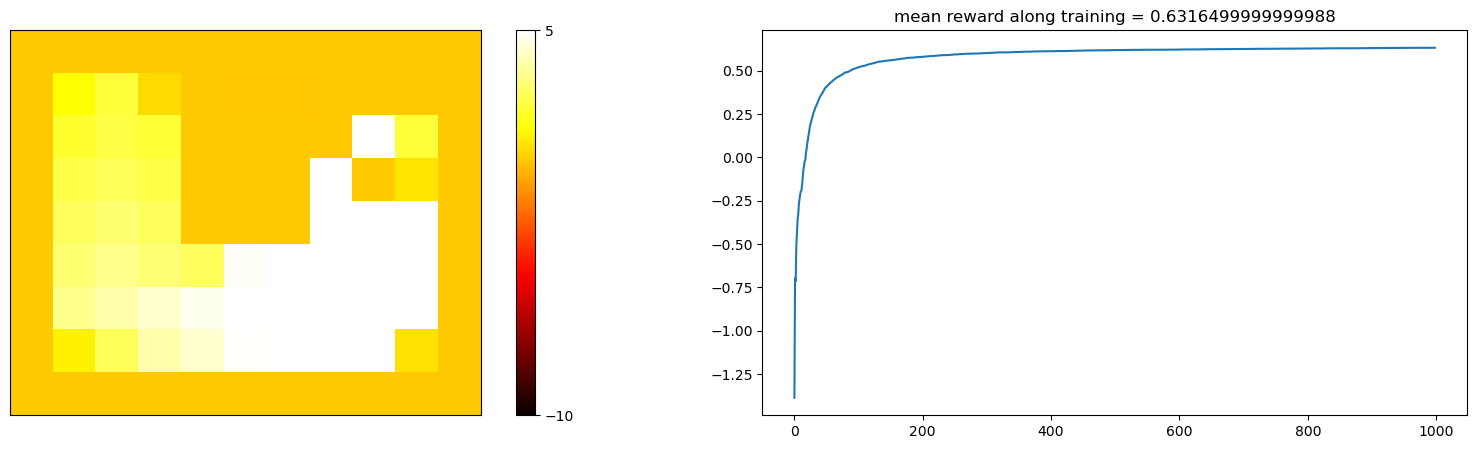

In [32]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

lmbda = 0.1

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = SarsaLambda(
    grid._layout.size, num_actions, lmbda, policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))



## Agent 4: Q-learning
**[10 pts]** Implement a **Q-learning** agent. The agent recevies a behavior policy at __init__, but always learns the Q values for the greedy policy.


In [33]:
class QLearning(object):

  def __init__(self, number_of_states, number_of_actions,
               policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    """TODO: Implement"""
    max = -np.Infinity
    action = 0
    for j in range(self._Qvalues.shape[1]):
      if self._Qvalues[next_state][j]>max:
        max = self._Qvalues[next_state][j]
        action = j
    self._Qvalues[self._state][self._action]+=self._step_size*(reward+discount*self._Qvalues[next_state][action] - self._Qvalues[self._state][self._action])
    self._action = self._policy.get_action(self._Qvalues,next_state)
    self._state = next_state
      
    return self._action



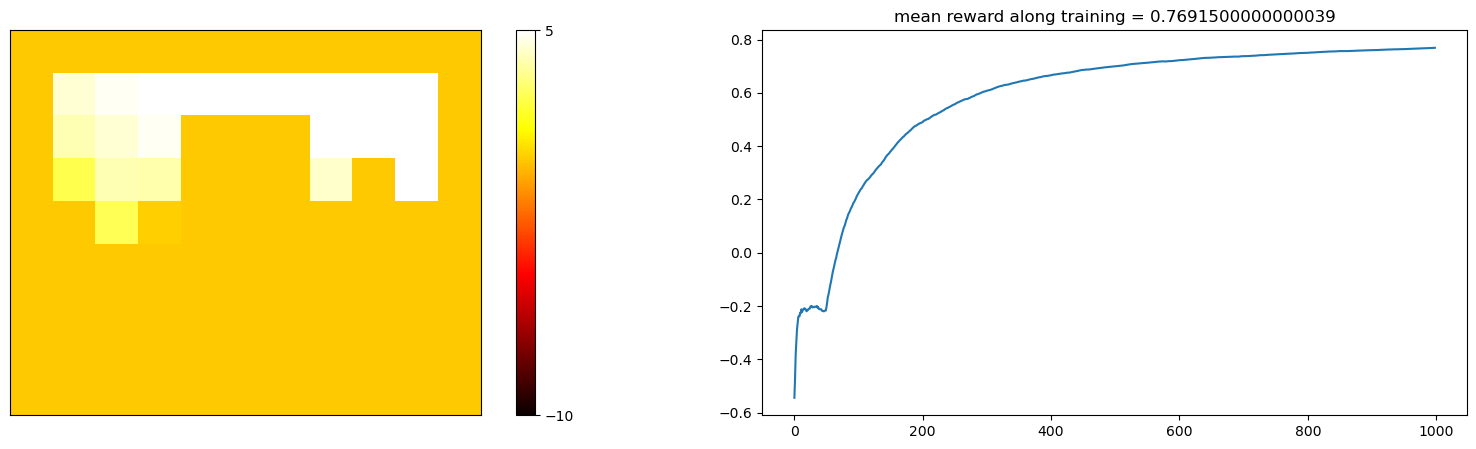

In [34]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = QLearning(grid._layout.size, num_actions, policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


## Agent 5: General Q-learning
**[15 pts]** Here you will consider a generalization of Q-learning and Sarsa.

Remember from class, that Q learning can be implemented using any two policies:
1. Behavior policy - used to act in the environment
2. Target policy - used as a target for the value updates.

Impement a **General Q-learning** agent, where the `__init__` takes as input a `target_policy` and a  `behavior_policy`.  The agent will act according to the behavior policy, and learn the Q-values of the target policy.
The TD target becomes:
$$r + \gamma \sum_a \mathcal{P}_s^{\texttt{target}}(a) Q(s, a))$$
where $s$ is the new state sent as input to the agent's `step` function.

The standard Q-learning is a special case where the target policy is the greedy policy, and Sarsa is the special case where the target policy is the same as the behavior policy.

**[5 pts]** To implement this, you will first need to add a function to the `EpsilonGreedy` class that returns the probabilities of all actions for a given state.

In [35]:
class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action_probs(self, Qvalues, state):
    """TODO: Implement"""
    # Tip: given a vector v, you can use np.eye(len(v))[np.argmax(v)]
    # to get a 'one-hot' vector which is zero everywhere except for a
    # one where the first max of v is.
    random_number = np.random.rand()
    if self._epsilon <= random_number:
      return np.full(Qvalues.shape[1],1.0/Qvalues.shape[1])
    else:
      v = Qvalues[state][:]
      action_probs = np.eye(len(v))[np.argmax(v)]
      return action_probs

  def get_action(self, Qvalues, state):
    """TODO: Implement"""
    random_number = np.random.rand()
    if random_number<=self._epsilon:
      return np.random.randint(Qvalues.shape[1])
    else:
      max = -np.Infinity
      action = 0
      for j in range(Qvalues.shape[1]):
        if Qvalues[state][j]>max:
          max = Qvalues[state][j]
          action = j

      return action



In [36]:
class GeneralQLearning(object):

  def __init__(self, number_of_states, number_of_actions,
               behavior_policy, target_policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._behavior_policy = behavior_policy
    self._target_policy = target_policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    """TODO: Implement"""
    
    prob_vecotr = self._target_policy.get_action_probs(self._Qvalues,next_state)
    TD_target = 0 
    for current_action in range(self._number_of_actions):
      TD_target+=prob_vecotr[current_action]*self._Qvalues[next_state][current_action]
    TD_target = discount*TD_target + reward
    TD_Error = TD_target - self._Qvalues[self._state][self._action]
    self._Qvalues[self._state][self._action] += self._step_size*TD_Error

    next_action = self._action = self._behavior_policy.get_action(self._Qvalues,next_state)
    self._state = next_state


    
    return next_action



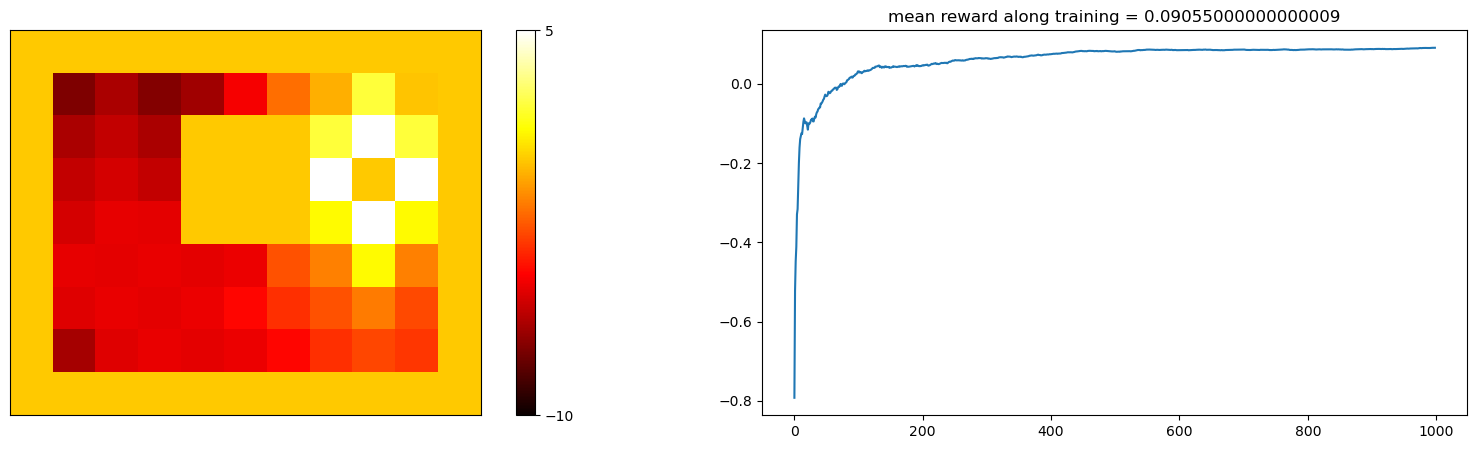

In [37]:
# DO NOT MODIFY THIS CELL
# set-up behavior and target policies
b_policy = EpsilonGreedy(0.5)
t_policy = EpsilonGreedy(0.)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = GeneralQLearning(grid._layout.size, num_actions,
                         b_policy, t_policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


# Part 2: Analyse Results

## Questions

**[10 pts]** *How* do the policies found by Q-learning and Sarsa differ?  (Explain qualitatively how the behaviour differs in one or two sentences.)

**[10 pts]** *Why* do the policies differ in this way?

**[5 pts]** Run the Sarsa($\lambda$) agent for different values of $\lambda$ (e.g. 0.1 and 0.9), and report the results.

**[5 pts]** Run the general Q-learning agent with different behavior policies and target policies, and report the results.

For the last two questions you can generate plots, reports statistics of rewards and/or values. You can also state any qualitative observation that you make.